In [1]:
train_dir = 'D:/Perkuliahan/S2/Semester 4/google_images/jatengdiy_class_colab/train/'
test_dir = 'D:/Perkuliahan/S2/Semester 4/google_images/jatengdiy_class_colab/test/'

In [2]:
#Number of images to load at each iteration
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

img_height, img_width = 224,224

batch_size = 32

train_datagen =  ImageDataGenerator(rescale=1./255)
test_datagen =  ImageDataGenerator(rescale=1./255)

# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(train_dir,target_size = (img_height, img_width),
                                                    batch_size = batch_size,class_mode = "categorical",
                                                    shuffle=True)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(test_dir,target_size = (img_height, img_width),
                                                 batch_size = batch_size,class_mode = "categorical",
                                                 shuffle=False)

Total number of images for "training":
Found 9649 images belonging to 3 classes.
Total number of images for "testing":
Found 2412 images belonging to 3 classes.


In [3]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 
from keras.applications.vgg16 import preprocess_input
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dropout
from tensorflow import keras
from keras.models import Sequential

In [4]:
# Checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint_filepath = 'D:/My Scripts/Github/Poverty Estimation/VGG16/L2_Model.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 1e-5, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, model_checkpoint_callback]

In [5]:
# Base Model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
for layer in conv_base.layers[:15]:
    layer.trainable=False

for layer in conv_base.layers[15:]:
    layer.trainable=True

model_l2 = Sequential()
model_l2.add(conv_base)
model_l2.add(Flatten(name='flatten'))
model_l2.add(Dense(32, name='my_dense', activation = 'relu', kernel_regularizer='l2'))
model_l2.add(Dense(3, activation='softmax'))
model_l2.summary()

opt = tf.keras.optimizers.Adam(learning_rate=6e-4)
model_l2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 my_dense (Dense)            (None, 32)                802848    
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 15,517,635
Trainable params: 7,882,371
Non-trainable params: 7,635,264
_________________________________________________________________


In [6]:
history_l2 = model_l2.fit(train_generator, epochs=100, shuffle=True, validation_data=test_generator, callbacks=callbacks, 
                              verbose=1)

Epoch 1/100
302/302 [==============================] - ETA: 0s - loss: 0.7677 - accuracy: 0.6869
Epoch 1: val_loss improved from inf to 0.60460, saving model to D:/My Scripts/Github/Poverty Estimation/VGG16\L2_Model.h5
302/302 [==============================] - 53s 154ms/step - loss: 0.7677 - accuracy: 0.6869 - val_loss: 0.6046 - val_accuracy: 0.7446
Epoch 2/100
302/302 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.7366
Epoch 2: val_loss did not improve from 0.60460
302/302 [==============================] - 44s 147ms/step - loss: 0.6083 - accuracy: 0.7366 - val_loss: 0.7036 - val_accuracy: 0.7177
Epoch 3/100
302/302 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.7579
Epoch 3: val_loss improved from 0.60460 to 0.57749, saving model to D:/My Scripts/Github/Poverty Estimation/VGG16\L2_Model.h5
302/302 [==============================] - 45s 148ms/step - loss: 0.5702 - accuracy: 0.7579 - val_loss: 0.5775 - val_accuracy: 0.7479
Epoch 4/100


In [7]:
import matplotlib.pyplot as plt 
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

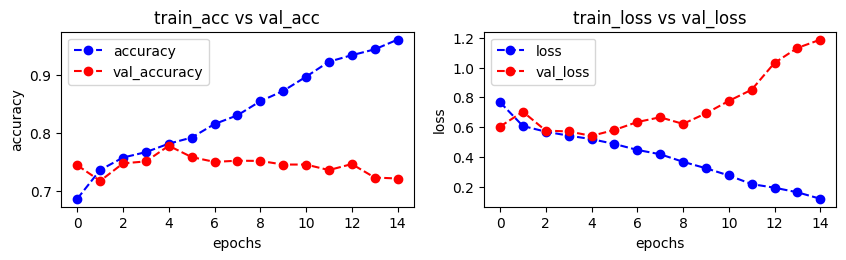

In [8]:
plot_accuracy_loss(history_l2)

In [9]:
score_l2 = model_l2.evaluate(test_generator, verbose=0)
print(score_l2)

[0.5423663258552551, 0.778192400932312]


In [10]:
import pandas as pd
hist_df = pd.DataFrame(history_l2.history)
hist_df.to_excel('D:/My Scripts/Github/Poverty Estimation/VGG16/L2_Model.xlsx')